# **Flower Classification**
---

The demonstrated notebook to the flower classification problem.

Tensorflow version: `2.16.1`

Required dependencies (other than `tensorflow`):
- `tensorflow_docs` (install via this [repo](git+https://github.com/tensorflow/docs))
- `tensorflow-datasets`
- `keras_tuner`
- `scikit-learn`

In [1]:
import os, logging

# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import keras
from keras import layers
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

Tensorflow version: 2.16.1


## Data Exploration

Data is prepared and packaged in two formats:
- `*_dataset`: tensorflow's `Dataset` where image and label are packed together
- `*_images`/`*_labels` pair: `numpy` arrays containing images and labels
separately

### Download and explore the dataset

The code assumes there's a `Flowers.zip` file containing the dataset sitting
in the `data` folder in the project directory.

Modify the `dataset_location` if the file is stored in another location.

In [2]:
import pathlib

# Get data from local disk
dataset_location = "./data/Flowers.zip"
dataset_url = f"file://{os.path.abspath(dataset_location)}"

# Download and cache the dataset
data_dir = keras.utils.get_file('Flowers.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

Verify the loaded path

In [3]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images: {image_count}")

fleurs0 = list(data_dir.glob('*/Fleurs0/*.jpg'))
print(f"Total number (train + test) of Fleurs0: {len(fleurs0)}")

Total number of images: 800
Total number (train + test) of Fleurs0: 80


Take a peak of an image

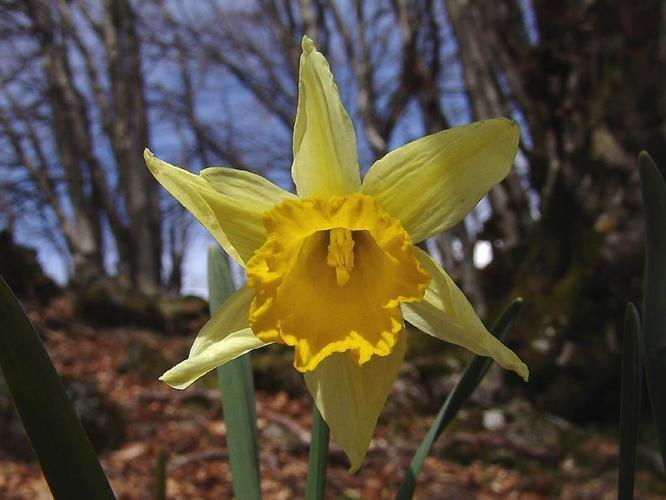

In [4]:
import PIL

PIL.Image.open(str(fleurs0[0]))

### Obtain datasets as keras datasets

Load images off disk as `tf.data.Dataset`s and resize them on the fly to the 
`128x128` size.

One nice feature of tensorflow `Dataset` is that most transform methods of this
class are implemented lazily. This means operations called on a `Dataset` won't 
be applied until it is being iterated over.

In [5]:
# Parameters for the loader
IMG_SIZE = 128

train_dataset = keras.utils.image_dataset_from_directory(
    directory=data_dir/"Train",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory=data_dir/"Test",
    shuffle=True,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")

Found 600 files belonging to 10 classes.


Found 200 files belonging to 10 classes.
Classes: ['Fleurs0', 'Fleurs1', 'Fleurs2', 'Fleurs3', 'Fleurs4', 'Fleurs5', 'Fleurs6', 'Fleurs7', 'Fleurs8', 'Fleurs9']


Manually convert `Dataset` to `numpy` arrays for operations cannot interface 
directly with it.

In [6]:
train_images = []
train_labels = []

test_images = []
test_labels = []

for (image, label) in train_dataset:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

for (image, label) in test_dataset:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Verify the conversion
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (600, 128, 128, 3)
Train labels shape: (600,)
Test images shape: (200, 128, 128, 3)
Test labels shape: (200,)


### Visualize the data

Plot some samples from the trainging set to verify the packaged datasets.

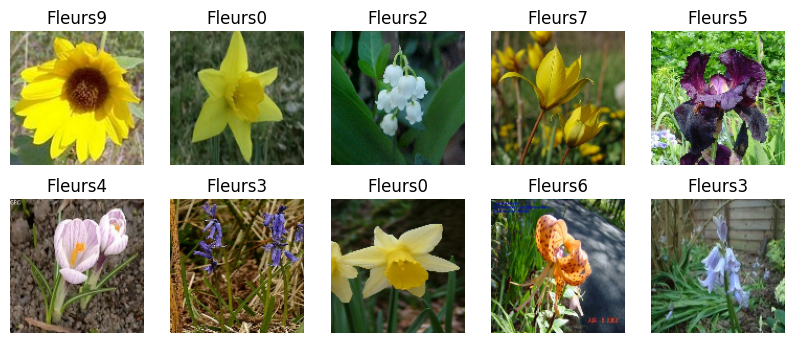

In [7]:
plt.figure(figsize=(10, 4))
for i, (image, label) in enumerate(train_dataset.take(10)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")

### Create preprocessing layers

The data must be preprocessed before training the network. There are two
preliminary steps to consider:
- Data resize and rescale
- Data augmentation

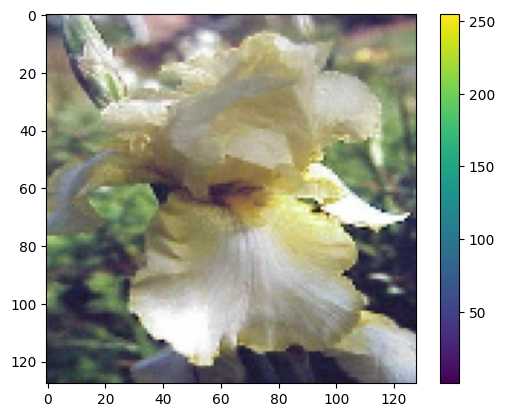

In [8]:
# Obtain a sample to visualize subsequent preprocessed steps
inspect_image, _ = next(iter(train_dataset))
# Add the image to a batch
inspect_image_batch = tf.cast(tf.expand_dims(inspect_image, 0), tf.float32)

plt.imshow(inspect_image.numpy().astype("uint8"))
plt.colorbar()

#### Resize and rescale pixel values

Create a layer to resize and rescale pixel values from `[0, 255]` to `[0, 1]`

Min and max pixel values: 0.0051968447 1.0


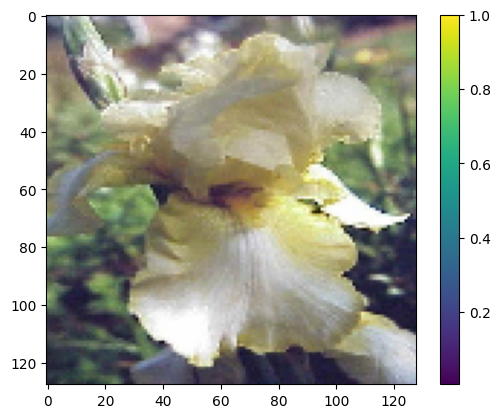

In [9]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
])

result = resize_and_rescale(inspect_image_batch)
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
_ = plt.imshow(result[0])
plt.colorbar()

#### Data augmentation

Create 2 variants of data augmentation layers.

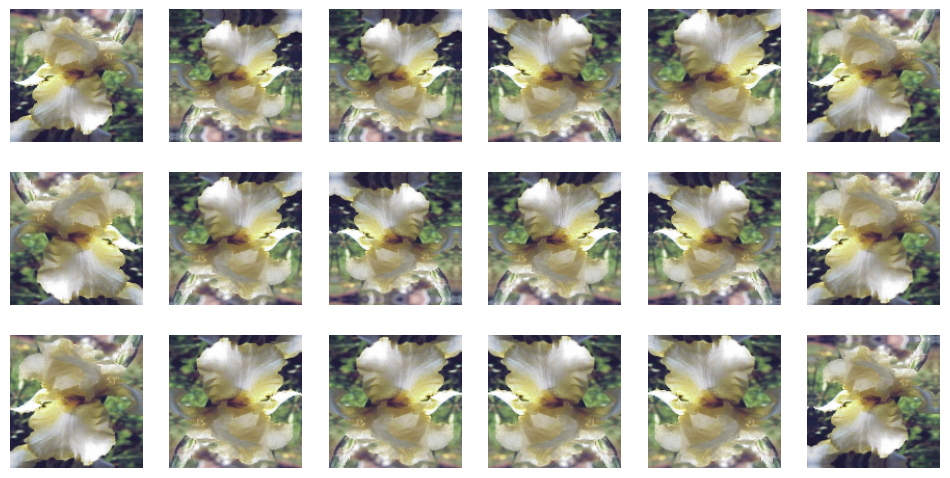

In [10]:
data_augmentation_substantial = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.1),
])

data_augmentation_miniscule = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])

plt.figure(figsize=(12, 6))
for i in range(18):
    augmented_image = data_augmentation_substantial(inspect_image_batch)
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

## Deep Neural Nets for Flower Classification

### Training configurations

In [11]:
BATCH_SIZE = 32
N_TRAINING = int(len(train_dataset) * 0.8)
N_VALIDATION = int(len(train_dataset) * 0.2)
STEPS_PER_EPOCH = N_TRAINING // BATCH_SIZE
BUFFER_SIZE = int(800)  # for shuffling
AUTOTUNE = tf.data.AUTOTUNE

print(f"Training size: {N_TRAINING}")
print(f"Validation size: {N_VALIDATION}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")

Training size: 480
Validation size: 120
Steps per epoch: 15


### Decay learing rate

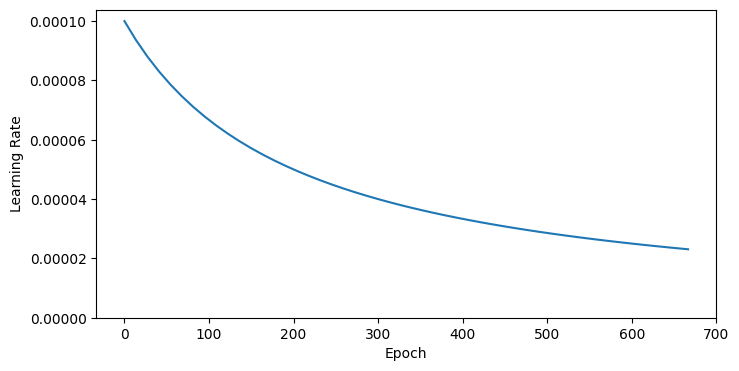

In [12]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.0001,
    decay_steps=STEPS_PER_EPOCH * 200,
    decay_rate=1,
    staircase=False,
)

step = np.linspace(0, 10000)
lr = lr_schedule(step)
plt.figure(figsize = (8, 4))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

### Configure training

The same training operation will be run for many different models in this step. 

The function `compile_and_fit` takes in a `keras.Sequential` instance and 
performs all necessary steps.

To prevent flooding the output cell, the `tfdocs.EpochDots` callback is 
used to prints only a `.` for each epoch, and a full set of metrics every 20 
epochs.

The training data is shuffled every time the `compile_and_fit` function is
called, creating the cross-validation effect. The shuffle is handled by the
`shuffle_training_data` method.

Due to a closed issue regarding the shuffle and splitting of `Dataset` discussed
[here](https://github.com/tensorflow/tensorflow/issues/50937), `numpy` format
is the plausible solution for this step.

In [13]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=5)
test_ds = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
rng = np.random.default_rng()
histories = {}

def compile_and_fit(model, max_epochs=500):
    optimizer = keras.optimizers.Adam(lr_schedule)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    model.summary()

    model_callbacks = [
        tfdocs.modeling.EpochDots(report_every=20),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=16),
    ]

    x, y = shuffle_training_data()

    history = model.fit(
        x,
        y,
        batch_size = BATCH_SIZE,
        epochs=max_epochs,
        validation_split=0.2,
        callbacks=model_callbacks,
        verbose=0,
    )

    return history


def shuffle_training_data():
    perm = rng.permutation(len(train_dataset))
    shuffled_images = train_images[perm]
    shuffled_labels = train_labels[perm]
    return (shuffled_images, shuffled_labels)


def average_run(model, name, repeat=3):
    val_accum = 0
    test_accum = 0

    for _ in range(repeat):
        history = compile_and_fit(model)
        val_accum = val_accum + max(history.history['val_accuracy'])
        _, test_accuracy = model.evaluate(test_ds, verbose=2)
        test_accum = test_accum + test_accuracy
    
    return (val_accum / repeat, test_accum / repeat)

### Tiny model

- Average validation accuracy: 62%
- Highest validation accuracy: 70%
- Average test accuracy: 50%

Model: "tiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,097,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097,962 (8.00 MB)

 Trainable params: 2,097,962 (8.00 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.1625,  loss:2.5659,  val_accuracy:0.1750,  val_loss:2.4617,  
....................
Epoch: 20, accuracy:0.3042,  loss:1.8737,  val_accuracy:0.3917,  val_loss:1.9203,  
....................
Epoch: 40, accuracy:0.3187,  loss:1.7740,  val_accuracy:0.3500,  val_loss:1.7752,  
....................
Epoch: 60, accuracy:0.3458,  loss:1.6924,  val_accuracy:0.3417,  val_loss:1.6976,  
....................
Epoch: 80, accuracy:0.3688,  loss:1.6312,  val_accuracy:0.3417,  val_loss:1.6816,  
....................
Epoch: 100, accuracy:0.3938,  loss:1.5641,  val_accuracy:0.3667,  val_loss:1.5937,  
....................
Epoch: 120, accuracy:0.3917,  loss:1.5278,  val_accuracy:0.3667,  val_loss:1.6196,  
....................
Epoch: 140, accuracy:0.4167,  loss:1.4838,  val_accuracy:0.3833,  val_loss:1.5760,  
....................
Epoch: 160, accuracy:0.4563,  loss:1.4428,  val_accuracy:0.3917,  val_loss:1.5666,  
........

Evaluation on test data:
7/7 - 0s - 60ms/step - accuracy: 0.34

[1.8462949991226196, 0.3449999988079071]

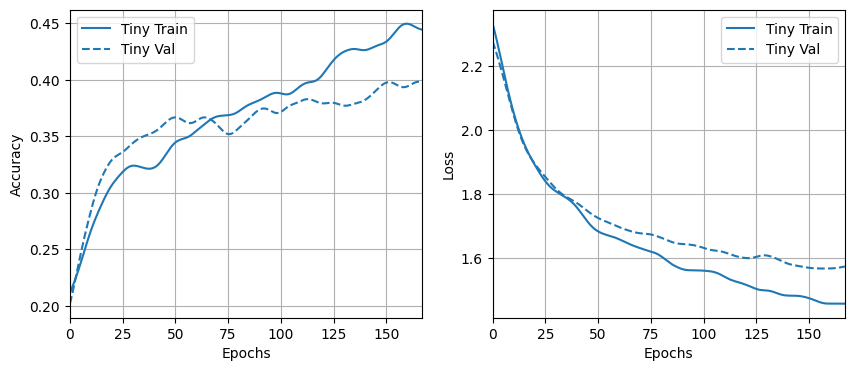

In [14]:
tiny_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation_miniscule,
    resize_and_rescale,
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.2),
    layers.Dense(len(class_names))
], name="tiny")

histories['tiny'] = compile_and_fit(tiny_model)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plotter.plot(histories, metric='accuracy')
plt.subplot(1, 2, 2)
plotter.plot(histories, metric='loss')

print("\n\nEvaluation on test data:")
tiny_model.evaluate(test_ds, verbose=2)

### Small model

- Average validation accuracy: 72%
- Highest validation accuracy: 79%
- Average test accuracy: 59%

Model: "small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 42)             │     1,376,298 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,381,816 (5.27 MB)

 Trainable params: 1,381,816 (5.27 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.1500,  loss:2.3749,  val_accuracy:0.2500,  val_loss:2.3357,  
....................
Epoch: 20, accuracy:0.5604,  loss:1.2332,  val_accuracy:0.6000,  val_loss:1.3060,  
....................
Epoch: 40, accuracy:0.6979,  loss:0.9429,  val_accuracy:0.6083,  val_loss:1.1003,  
....................
Epoch: 60, accuracy:0.7563,  loss:0.7756,  val_accuracy:0.6583,  val_loss:0.9882,  
....................
Epoch: 80, accuracy:0.8375,  loss:0.5968,  val_accuracy:0.6667,  val_loss:0.9037,  
......

Evaluate on test set:
7/7 - 0s - 54ms/step - accuracy: 0.6200 - loss: 1.2951


[1.295060157775879, 0.6200000047683716]

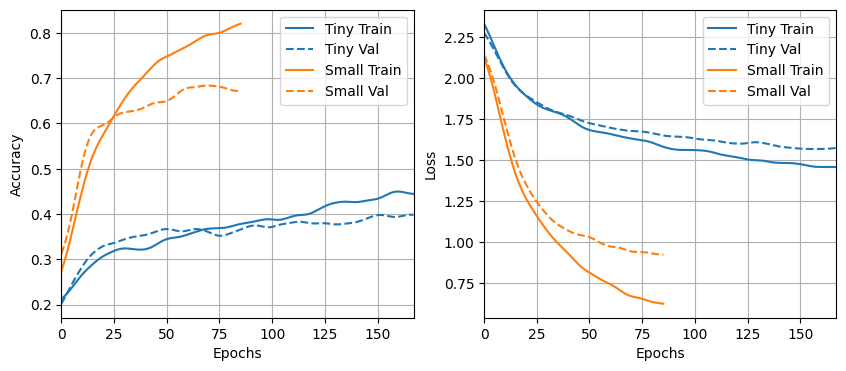

In [15]:
small_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation_miniscule,
    resize_and_rescale,
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(42, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(len(class_names)),
], name="small")

histories['small'] = compile_and_fit(small_model)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plotter.plot(histories, metric='accuracy')
plt.subplot(1, 2, 2)
plotter.plot(histories, metric='loss')

print("\n\nEvaluate on test set:")
small_model.evaluate(test_ds, verbose=2)

### Medium model

- Average validation accuracy: 75%
- Highest validation accuracy: 80%
- Average test accuracy: 62%

Model: "medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │     1,572,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,606,826 (6.13 MB)

 Trainable params: 1,606,826 (6.13 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.1271,  loss:2.8574,  val_accuracy:0.0833,  val_loss:2.8237,  
....................
Epoch: 20, accuracy:0.5667,  loss:1.5168,  val_accuracy:0.6083,  val_loss:1.5020,  
....................
Epoch: 40, accuracy:0.7229,  loss:1.0793,  val_accuracy:0.6750,  val_loss:1.2113,  
....................
Epoch: 60, accuracy:0.7688,  loss:0.9106,  val_accuracy:0.6833,  val_loss:1.1701,  
....................
Epoch: 80, accuracy:0.7896,  loss:0.8117,  val_accuracy:0.7000,  val_loss:1.1012,  
..................

Evaluate on test set:
7/7 - 0s - 47ms/step - accuracy: 0.6450 - loss: 1.4320


[1.432021975517273, 0.6449999809265137]

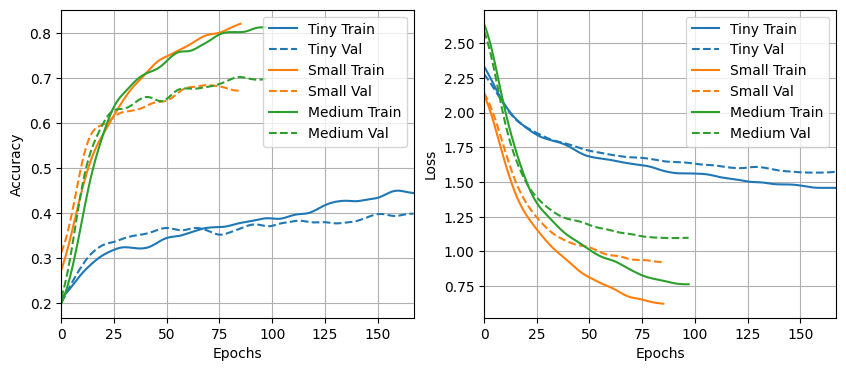

In [16]:
medium_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation_substantial,
    resize_and_rescale,
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.2),
    layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.2),
    layers.Dense(len(class_names))
], name="medium")

histories['medium'] = compile_and_fit(medium_model)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plotter.plot(histories, metric='accuracy')
plt.subplot(1, 2, 2)
plotter.plot(histories, metric='loss')

print("\n\nEvaluate on test set:")
medium_model.evaluate(test_ds, verbose=2)

### Large model

- Average validation accuracy: 71%
- Highest validation accuracy: 81%
- Average test accuracy: 67%

Model: "large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,159,210 (4.42 MB)

 Trainable params: 1,159,210 (4.42 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.0958,  loss:9.9396,  val_accuracy:0.1083,  val_loss:9.5505,  
....................
Epoch: 20, accuracy:0.4479,  loss:4.1556,  val_accuracy:0.4917,  val_loss:4.0782,  
....................
Epoch: 40, accuracy:0.6375,  loss:3.0265,  val_accuracy:0.6083,  val_loss:3.0216,  
....................
Epoch: 60, accuracy:0.7083,  loss:2.4349,  val_accuracy:0.6667,  val_loss:2.5776,  
....................
Epoch: 80, accuracy:0.7875,  loss:2.0695,  val_accuracy:0.7083,  val_loss:2.2940,  
....................
Epoch: 100, accuracy:0.8333,  loss:1.7823,  val_accuracy:0.7250,  val_loss:2.1823,  
....................
Epoch: 120, accuracy:0.8792,  loss:1.6101,  val_accuracy:0.7333,  val_loss:2.0244,  
....................
Epoch: 140, accuracy:0.8875,  loss:1.4662,  val_accuracy:0.7500,  val_loss:1.8782,  
....................
Epoch: 160, accuracy:0.8958,  loss:1.3531,  val_accuracy:0.7500,  val_loss:1.8717,  
....................
Epoch: 180, accuracy:0.9292,  loss:1.2451,  val_acc

[2.4575679302215576, 0.675000011920929]

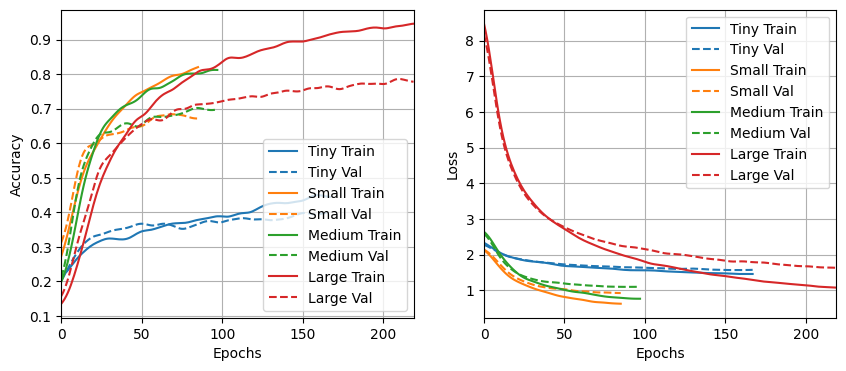

In [17]:
large_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation_miniscule,
    resize_and_rescale,
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(len(class_names))
], name="large")

histories['large'] = compile_and_fit(large_model)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plotter.plot(histories, metric='accuracy')
plt.subplot(1, 2, 2)
plotter.plot(histories, metric='loss')

print("\n\nEvaluate on test set:")
large_model.evaluate(test_ds, verbose=2)

## SVM Baseline

The `numpy` datasets must be flattend before feeding to the classifier.

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Flatten and rescale the images
train_images_svm = train_images.reshape(train_images.shape[0], -1)
train_images_svm = train_images_svm / 255.

test_images_svm = test_images.reshape(test_images.shape[0], -1)
test_images_svm = test_images_svm / 255.

### SVM with default parameters

In [16]:
svm_classifier = SVC()
svm_classifier.fit(train_images_svm, train_labels)

svm_predicts = svm_classifier.predict(test_images_svm)

svm_accuracy = accuracy_score(test_labels, svm_predicts)
print(f"SVM accuracy with default parameters: {svm_accuracy}")

SVM accuracy with default parameters: 0.405


### SVM with optimal parameters from grid search

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01],               # regularization parameter
    'gamma': ['scale', 'auto', 0.01], # kernel coefficient
    'kernel': ['linear', 'rbf']       # kernel type
}

svm_classifier = SVC()
grid_search = GridSearchCV(
    estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=10
)

grid_search.fit(train_images_svm, train_labels)

best_params = grid_search.best_params_
print(f"Optimal parameters: {best_params}")

svm_optimal = grid_search.best_estimator_
svm_predicts = svm_optimal.predict(test_images_svm)
svm_accuracy = accuracy_score(test_labels, svm_predicts)
print(f"SVM accuracy with optimal parameters: {svm_accuracy}")

Optimal parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
SVM accuracy with optimal parameters: 0.445


## Hyper-parameter tunning

Tune the hyper-parameters of our potential models, using the `keras_tuner` API.

### Model builders

First define some model builder function so that the tuner can instantiate our 
models using the supplied hyperparameter `hp`.

Define one builder for each of the `small_model`, `medium_model`, and
`large_model`.

In [14]:
def model_builder_small(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(data_augmentation_miniscule)
    model.add(resize_and_rescale)
    model.add(layers.Conv2D(16, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Tune the dropout fraction in the flatten layer
    hp_dropout_flatten = hp.Choice('dropout_flatten', values=[0.1, 0.2, 0.3])
    model.add(layers.Dropout(hp_dropout_flatten))

    # Tune the regularization factor
    hp_l2 = hp.Choice('l2_factor', values=[0.001, 0.002])

    # Tune the number of units in the first dense layer
    hp_units_dense1 = hp.Int('units_dense1', min_value=32, max_value=64, step=4)
    model.add(layers.Dense(
        units=hp_units_dense1, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the first dense layer
    hp_dropout_dense1 = hp.Choice('dropout_dense1', values=[0.2, 0.3])
    model.add(layers.Dropout(hp_dropout_dense1))

    model.add(layers.Dense(len(class_names)))

    optimizer = keras.optimizers.Adam(lr_schedule)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    return model

In [15]:
def model_builder_medium(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(data_augmentation_substantial)
    model.add(resize_and_rescale)
    model.add(layers.Conv2D(16, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Tune the dropout fraction in the flatten layer
    hp_dropout_flatten = hp.Choice('dropout_flatten', values=[0.1, 0.2, 0.3])
    model.add(layers.Dropout(hp_dropout_flatten))

    # Tune the regularization factor
    hp_l2 = hp.Choice('l2_factor', values=[0.001, 0.002, 0.003, 0.004])

    # Tune the number of units in the first dense layer
    hp_units_dense1 = hp.Int('units_dense1', min_value=64, max_value=96, step=8)
    model.add(layers.Dense(
        units=hp_units_dense1, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the first dense layer
    hp_dropout_dense1 = hp.Choice('dropout_dense1', values=[0.1, 0.2, 0.3])
    model.add(layers.Dropout(hp_dropout_dense1))

    # Tune the number of units in the second dense layer
    hp_units_dense2 = hp.Int('units_dense2', min_value=64, max_value=96, step=8)
    model.add(layers.Dense(
        units=hp_units_dense2, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the second dense layer
    hp_dropout_dense2 = hp.Choice('dropout_dense2', values=[0.1, 0.2, 0.3])
    model.add(layers.Dropout(hp_dropout_dense2))

    model.add(layers.Dense(len(class_names)))

    optimizer = keras.optimizers.Adam(lr_schedule)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    return model

In [16]:
def model_builder_large(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(data_augmentation_miniscule)
    model.add(resize_and_rescale)
    model.add(layers.Conv2D(16, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding="same", activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Tune the dropout fraction in the flatten layer
    hp_dropout_flatten = hp.Choice('dropout_flatten', values=[0.1, 0.2, 0.3, 0.4])
    model.add(layers.Dropout(hp_dropout_flatten))

    # Tune the regularization factor
    hp_l2 = hp.Choice('l2_factor', values=[0.2, 0.3, 0.4])
    
    # Tune the number of units in the first dense layer
    hp_units_dense1 = hp.Int('units_dense1', min_value=32, max_value=96, step=8)
    model.add(layers.Dense(
        units=hp_units_dense1, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the first dense layer
    hp_dropout_dense1 = hp.Choice('dropout_dense1', values=[0.1, 0.2, 0.3, 0.4])
    model.add(layers.Dropout(hp_dropout_dense1))

    # Tune the number of units in the second dense layer
    hp_units_dense2 = hp.Int('units_dense2', min_value=32, max_value=96, step=8)
    model.add(layers.Dense(
        units=hp_units_dense2, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the second dense layer
    hp_dropout_dense2 = hp.Choice('dropout_dense2', values=[0.1, 0.2, 0.3, 0.4])
    model.add(layers.Dropout(hp_dropout_dense2))


    # Tune the number of units in the third dense layer
    hp_units_dense3 = hp.Int('units_dense3', min_value=32, max_value=96, step=8)
    model.add(layers.Dense(
        units=hp_units_dense3, activation='relu', 
        kernel_regularizer=regularizers.l2(hp_l2)
    ))

    # Tune the dropout fraction in the second dense layer
    hp_dropout_dense3 = hp.Choice('dropout_dense3', values=[0.1, 0.2, 0.3, 0.4])
    model.add(layers.Dropout(hp_dropout_dense3))
    
    model.add(layers.Dense(len(class_names)))

    # Tune the learning rate
    # Choose an optimal value from 0.00001, 0.00005, 0.0001, 0.0005, and 0.001
    # hp_eta = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4, 5e-4, 1e-3])
    optimizer = keras.optimizers.Adam(lr_schedule)
    
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    return model

### Generic tuning procedure

Define a reusable function to instantiate a tuner according to the supplied 
`builder`.

The function:
- Performs tuner search
- Builds the model with the best optimal hyper-parameters
- Finds the best number of epochs
- Reruns the training with the optimal number of epochs

In [17]:
import keras_tuner as kt

MAX_EPOCHES_SMALL = 200
MAX_EPOCHES_MEDIUM = 220
MAX_EPOCHES_LARGE = 240

def tuner_search(builder, name, max_epoches):
    tuner = kt.Hyperband(
        builder, objective='val_accuracy', max_epochs=max_epoches,
        factor=3, directory=f"tuner/{name}", project_name='flower',
    )

    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=14)
    
    x, y = shuffle_training_data()
    
    tuner.search(
        x, y, batch_size=BATCH_SIZE, epochs=max_epoches, 
        validation_split=0.2, callbacks=[stop_early],
    )

    print(f"\nBuild and fit optimal model:")
    
    best_hps = tuner.get_best_hyperparameters()[0]
    optimal_model = tuner.hypermodel.build(best_hps)
    history = optimal_model.fit(
        x, y, batch_size=BATCH_SIZE, epochs=max_epoches, validation_split=0.2,
        callbacks=[tfdocs.modeling.EpochDots(report_every=60)], verbose=0
    )

    val_accuracy_per_epoch = history.history['val_accuracy']
    best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1
    print(f"\nBest number of epoch: {best_epoch}")

    print(f"\nBuild and fit with the whole data and best number of epoches:")
    optimal_model = tuner.hypermodel.build(best_hps)
    optimal_model.fit(
        x, y, batch_size=BATCH_SIZE, epochs=best_epoch, verbose=0,
        callbacks=[tfdocs.modeling.EpochDots(report_every=60)]
    )

    return optimal_model

### Hyper-parameter searching

Perform tuner search on the small model

In [18]:
optimal_small_model = tuner_search(model_builder_small, 'small', MAX_EPOCHES_SMALL)

print("\nSmall model performance on newly seen data:")
loss_small, acc_small = optimal_small_model.evaluate(test_ds, verbose=3)
print(f"Loss: {loss_small:.{4}f} - Accuracy: {acc_small:.{2}f}")

Reloading Tuner from tuner/small/flower/tuner0.json

Build and fit optimal model:

Epoch: 0, accuracy:0.1021,  loss:2.3727,  val_accuracy:0.1083,  val_loss:2.3503,  
............................................................
Epoch: 60, accuracy:0.7833,  loss:0.7101,  val_accuracy:0.7083,  val_loss:0.7531,  
............................................................
Epoch: 120, accuracy:0.8813,  loss:0.4224,  val_accuracy:0.6917,  val_loss:0.7201,  
............................................................
Epoch: 180, accuracy:0.9167,  loss:0.3294,  val_accuracy:0.7083,  val_loss:0.6926,  
....................
Best number of epoch: 85

Build and fit with the whole data and best number of epoches:

Epoch: 0, accuracy:0.1100,  loss:2.3626,  
............................................................
Epoch: 60, accuracy:0.7200,  loss:0.8361,  
.........................Small model performance on newly seen data:
Loss: 1.2568 - Accuracy: 0.55


Perform tuner search on the medium model

In [19]:
optimal_medium_model = tuner_search(model_builder_medium, 'medium', MAX_EPOCHES_MEDIUM)

print("\nMedium model performance on newly seen data:")
loss_medium, acc_medium = optimal_medium_model.evaluate(test_ds, verbose=3)
print(f"Loss: {loss_medium:.{4}f} - Accuracy: {acc_medium:.{2}f}")

Reloading Tuner from tuner/medium/flower/tuner0.json

Build and fit optimal model:

Epoch: 0, accuracy:0.1083,  loss:3.0812,  val_accuracy:0.1583,  val_loss:3.0254,  
............................................................
Epoch: 60, accuracy:0.7750,  loss:1.0331,  val_accuracy:0.7250,  val_loss:1.2856,  
............................................................
Epoch: 120, accuracy:0.9062,  loss:0.6645,  val_accuracy:0.7750,  val_loss:1.1421,  
............................................................
Epoch: 180, accuracy:0.9250,  loss:0.5500,  val_accuracy:0.7583,  val_loss:1.1604,  
........................................
Best number of epoch: 179

Build and fit with the whole data and best number of epoches:

Epoch: 0, accuracy:0.1367,  loss:3.0706,  
............................................................
Epoch: 60, accuracy:0.7750,  loss:0.9720,  
............................................................
Epoch: 120, accuracy:0.8800,  loss:0.6926,  
...........

Perform tuner search on the large model

In [20]:
optimal_large_model = tuner_search(model_builder_large, 'large', MAX_EPOCHES_LARGE)

print("\nLarge model performance on newly seen data:")
loss_large, acc_large = optimal_large_model.evaluate(test_ds, verbose=3)
print(f"Loss: {loss_large:.{4}f} - Accuracy: {acc_large:.{2}f}")

Reloading Tuner from tuner/large/flower/tuner0.json

Build and fit optimal model:

Epoch: 0, accuracy:0.1146,  loss:51.7281,  val_accuracy:0.1167,  val_loss:49.1451,  
............................................................
Epoch: 60, accuracy:0.6042,  loss:9.0639,  val_accuracy:0.6417,  val_loss:8.9966,  
............................................................
Epoch: 120, accuracy:0.7854,  loss:4.0579,  val_accuracy:0.6750,  val_loss:4.3130,  
............................................................
Epoch: 180, accuracy:0.8521,  loss:2.2165,  val_accuracy:0.7083,  val_loss:2.6023,  
............................................................
Best number of epoch: 213

Build and fit with the whole data and best number of epoches:

Epoch: 0, accuracy:0.0850,  loss:51.1159,  
............................................................
Epoch: 60, accuracy:0.5683,  loss:7.4817,  
............................................................
Epoch: 120, accuracy:0.7167,  loss

### Inspect model performance

Add a probability layer on top of one of the optimal models.

In [84]:
probability_model = keras.Sequential([
    optimal_large_model,
    keras.layers.Softmax()
])
predictions = probability_model.predict(test_images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


Define 2 utility functions for plotting the predictions

In [130]:
def plot_image(prediction, true_label, image):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image.astype("uint8"))

    predicted_label = np.argmax(prediction)
    if predicted_label == true_label:
        color = '#003300'
    else:
        color = '#990000'

    prob = 100 * np.max(prediction)
    predicted_class = class_names[predicted_label]
    true_class = class_names[true_label]
    plt.xlabel(f"{predicted_class} {prob:.{2}f}% ({true_class})", color=color)

def plot_prob(prediction, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    plt.ylim([0, 1])

    prob_plot = plt.bar(range(10), prediction, color="#777777")
    predicted_label = np.argmax(prediction)
    prob_plot[predicted_label].set_color('#990000')
    prob_plot[true_label].set_color('#003300')

    pass

Pick a random test sample and observe the model's prediction

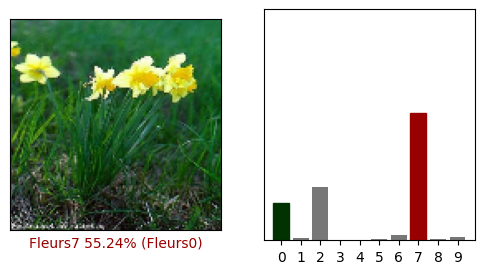

In [149]:
sample = np.random.randint(201)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(predictions[sample], test_labels[sample], test_images[sample])
plt.subplot(1, 2, 2)
plot_prob(predictions[sample], test_labels[sample])

Apply the same operations to 12 random test samples

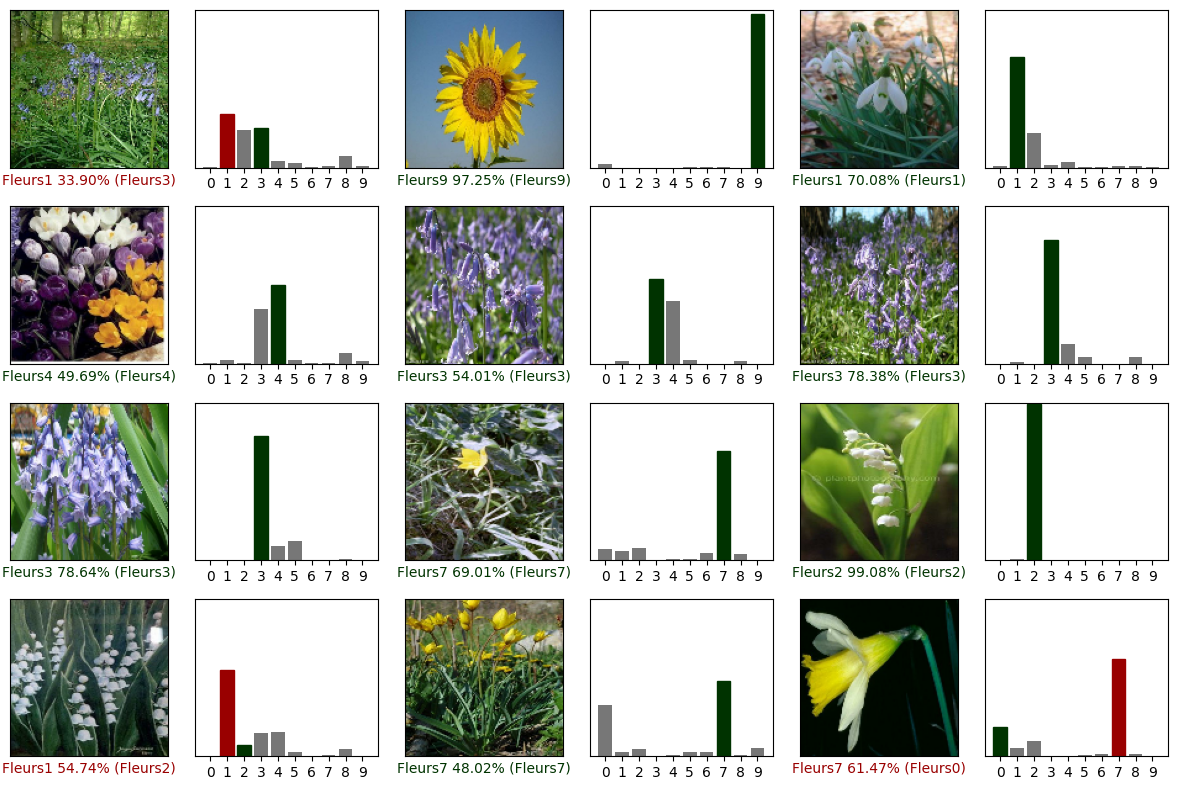

In [150]:
rows = 4
cols = 3
plot_count = rows * cols

plt.figure(figsize=(2 * 2 * cols, 2 * rows))

for i in range(plot_count):
    sample = np.random.randint(201)

    plt.subplot(rows, 2 * cols, 2 * i + 1)
    plot_image(predictions[sample], test_labels[sample], test_images[sample])
    
    plt.subplot(rows, 2 * cols, 2 * i + 2)
    plot_prob(predictions[sample], test_labels[sample])

plt.tight_layout()
plt.show()

## Transfer Learning

The [MobileNet V2](https://arxiv.org/abs/1801.04381) is employed as a base
feature extractor.

The pre-trained model can be retrieved quickly using `keras`'s `applications`
module.

### Preprocess datasets

Create a training, validation, and test `Dataset` similar to how they were split 
in previous steps

In [27]:
training_dataset = train_dataset.skip(N_VALIDATION)
validation_dataset = train_dataset.take(N_VALIDATION)

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Training dataset size: 480
Validation dataset size: 120


Configure the data for performance:
- `cache`: transforms are only invoked once in the first iteration over the data
- `repeat`: expand the data indefinitely
- `prefetch`: prevent I/O bottleneck

In [28]:
training_ds = training_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### Create the base model from the pre-trained convnets

First pick the convolutional layers of MobileNet V2 for feature extraction.

The `weights` parameter specifies which dataset the weights of the returned
should adjusted to.

In [29]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet',
)

Inspect what the base model does to an example batch of images in subsequent
steps:

In [30]:
image_batch, label_batch = next(iter(training_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


### Feature extraction

Freeze the convolutional base created from the previous step and to use 
as a feature extractor.

In [31]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

The feature extractor converts each `128x128x3` image into a `4x4x1280` block of 
features. 

The `GlobalAveragePooling2D` converts these features to a single `1280`-element 
vector per image.

In [32]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Inspect the effect of batch average
print(feature_batch_average.shape)

(32, 1280)


Use the `Dense` layer with 10 units as the output layer

In [33]:
prediction_layer = keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)

# Inspect the prediction for a batch
print(prediction_batch.shape)

(32, 10)


Build the model, similar to what has been done before

In [34]:
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation_miniscule(input_layer)
a = preprocess_input(a)
a = base_model(a, training=False)
a = global_average_layer(a)
a = keras.layers.Dropout(0.2)(a)
output_layer = prediction_layer(a)

transfer_model = keras.Model(input_layer, output_layer)
transfer_model.summary()

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compile the model, using the same loss function as before.

In [35]:
base_learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=base_learning_rate)
loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

transfer_model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

### Train the model

It's better to see the performance of the model prior to training.

In [36]:
loss0, accuracy0 = transfer_model.evaluate(validation_ds)
print(f"Initial loss: {loss0}")
print(f"Initial accuracy: {accuracy0}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.1069 - loss: 2.8735
Initial loss: 3.024440288543701
Initial accuracy: 0.10833333432674408


Train for a few number of epochs

In [37]:
initial_epochs = 20
transfer_history = transfer_model.fit(
    training_ds, 
    epochs=initial_epochs, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    validation_data=validation_ds,
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.1279 - loss: 3.0271 - val_accuracy: 0.1167 - val_loss: 2.6884
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1727 - loss: 2.6633 - val_accuracy: 0.1583 - val_loss: 2.4226
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.2036 - loss: 2.4247 - val_accuracy: 0.2667 - val_loss: 2.2032
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2587 - loss: 2.2097 - val_accuracy: 0.3583 - val_loss: 2.0136
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.2860 - loss: 2.0763 - val_accuracy: 0.4250 - val_loss: 1.8530
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.3662 - loss: 1.8579 - val_accuracy: 0.4667 - val_loss: 1.7086
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4319 - loss: 1.7612 - val_accuracy: 0.5500 - val_loss: 1.5749
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4878 - loss: 1.7209 - val_accuracy: 0.583

Evaluate the transfer model on the test dataset

In [38]:
transfer_model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.6584 - loss: 1.0789


[1.0075660943984985, 0.6850000023841858]

### Lerning curve

Plot the training and validation trends

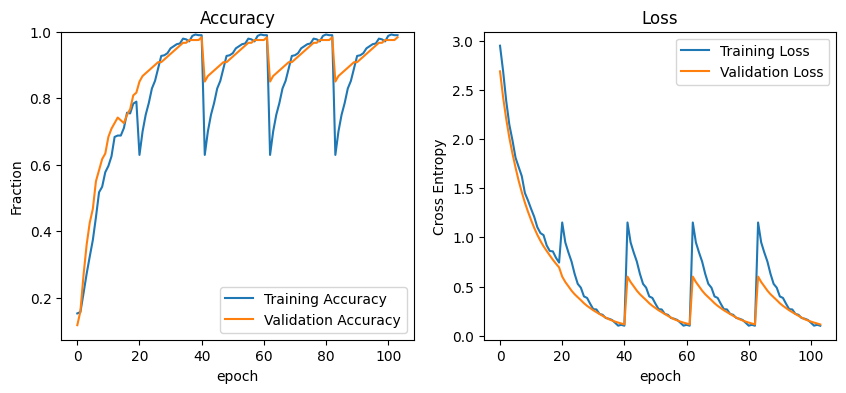

In [60]:
acc = transfer_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy']

loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Fraction')
plt.ylim([min(plt.ylim()), 1])
plt.xlabel('epoch')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

Update the weights of the pre-trained network alongside the training of the 
classifier

In [40]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Fine-tune only a small number of top layers rather than the whole MobileNet model.

In [41]:
fine_tune_at = 100

# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

It is important to use a lower learning rate at this stage since the model has
been trained previously

In [42]:
optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)
loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

transfer_model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
transfer_model.summary()

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,874,250 (7.15 MB)

 Non-trainable params: 396,544 (1.51 MB)

Train and fine tune the model

In [43]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

fine_history = transfer_model.fit(
    training_ds, 
    epochs=total_epochs, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    validation_data=validation_ds,
    initial_epoch=transfer_history.epoch[-1],
)

Epoch 20/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.6186 - loss: 1.1674 - val_accuracy: 0.8500 - val_loss: 0.6009
Epoch 21/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.7043 - loss: 0.8994 - val_accuracy: 0.8667 - val_loss: 0.5458
Epoch 22/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.7383 - loss: 0.8919 - val_accuracy: 0.8750 - val_loss: 0.5023
Epoch 23/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.7777 - loss: 0.7705 - val_accuracy: 0.8833 - val_loss: 0.4580
Epoch 24/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.8291 - loss: 0.6262 - val_accuracy: 0.8917 - val_loss: 0.4215
Epoch 25/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.8538 - loss: 0.5286 - val_accuracy: 0.9000 - val_loss: 0.3911
Epoch 26/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.8677 - loss: 0.5301 - val_accuracy: 0.9083 - val_loss: 0.3615
Epoch 27/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.9280 - loss: 0.3900 - val_acc

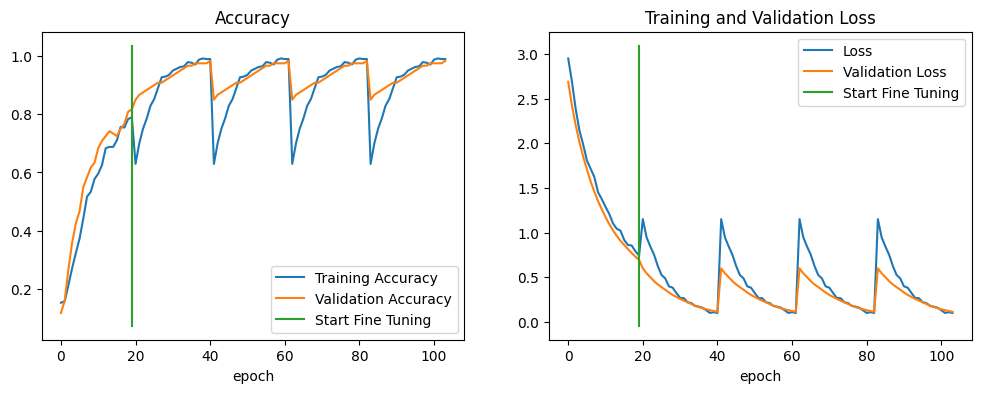

In [59]:
acc += fine_history.history['accuracy']
val_acc += fine_history.history['val_accuracy']

loss += fine_history.history['loss']
val_loss += fine_history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [77]:
loss_fine, accuracy_fine = transfer_model.evaluate(test_ds)
print('Fine-tuned performance on newly seen data:')
print(f"Loss: {loss_fine:.{4}f} - Accuracy: {accuracy_fine:.{2}f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7868 - loss: 0.5744
Fine-tuned performance on newly seen data:
Loss: 0.4810 - Accuracy: 0.81
